# Machine Learning for Malware Detection

The original tutorials are given in: http://resources.infosecinstitute.com/machine-learning-malware-detection/

### Introduction

Machine Learning is a subfield of computer science that aims to give computers the ability to learn from data instead of being explicitly programmed, thus leveraging the petabytes of data that exists on the internet nowadays to make decisions, and do tasks that are somewhere impossible or just complicated and time consuming for us humans.

Malware is one the imminent threats that companies and users face every day. Whether it is a phishing email or an exploit delivered throughout the browser, coupled with multiple evasion methods and other security vulnerabilities, it is a proven fact that **nowadays defense systems cannot compete**. The availability of frameworks such as Veil, Shelter, and others are known to be used by professionals when conducting pentesting work and are known to be quite effective.

Today I am going to show you that indeed **Machine Learning can be used to detect Malware without having to use neither a signature detection nor a behavioral analysis**.

P.S: Many products nowadays like CylanceProtect, SentinelOne, Carbon Black are known to leverage these capabilities the framework we are going to develop trough out this session is not at any level capable of doing what these products do, and I will explain shortly why.

### Machine Learning a brief Introduction

Machine Learning is a subfield that mixes many domains of mathematics mainly Statistics and Probabilities and Linear Algebra and Computation (Algorithms, Data Processing, Numerical Calculations). To gain insight from data it is used to detect fraud, spam and recommending movies and meals and products to buy, Amazon, Facebook, Google to name a few of the hundreds of companies that use Machine learning to improve their products.

Machine Learning can be split into two major methods **supervised learning and unsupervised learning** the first means that the data we are going to work with is labeled the second means it is unlabeled, detecting malware can be attacked using both methods, but we will focus on the first one since our goal is to **classify** files.

Classification is a sub domain of supervised learning it can be either binary (malware-notMalware) or multi-class (cat-dog-pig-lama…) thus malware detection falls under binary classification.

Explaining Machine Learning is beyond this article, and nowadays you can find a large amount of resources to know more about it, and you can check the Appendix for more of these resources.

### The Problem Set

Machine Learning works by defining a problem, collecting the data, processing the data to make it usable and then feeding it to the algorithms. This makes it quite hard to implement in everything for the extensive amount of resources you may need to do this; this is called the machine learning workflow it is the minimal steps you need to start doing Machine Learning.

In our case let’s define our workflow:

- First, we need to **collect malware samples** and **clean samples** we cannot work with less than 10k samples of both, and it is advisable to use even more of these
- We need to **extract meaningful features** from our samples these features will be the basis of our study; features are what describe something, for example, the features of a house are:
    - number of rooms
    - SQ foot of the house
    - price
- After extracting these features, we need to process all our samples to **build a dataset** it can be a database file or a CSV file this way it will be easier to turn it into vectors since the algorithms work by performing computation on vectors
- Lastly, we need **metrics** in this binary classification there are a multitude of metrics to benchmark the performance of an algorithm (ROC/AUC, Confusion Matrix…) we will use a confusion matrix since it represents the rates of True Positives and True Negatives as well as False Positives and False Negatives.

### Collecting Samples and Feature Extraction

I assume the reader knows about the PE File Format if you do not you can read about it [here](http://resources.infosecinstitute.com/2-malware-researchers-handbook-demystifying-pe-file/), collecting samples is quite easy you can either use a paid service like (VirusTotal) or one of the links [here](https://zeltser.com/malware-sample-sources/)

Okay, let’s start on by discussing our model.

For our algorithm to learn from the data you feed it we need to make that data understandable and clear, in our case, we will use **12 features*** to teach our algorithm these features will be extracted from each binary and organized into a CSV file once.

### Feature Extraction

To extract features, we will be using [pefile](https://github.com/erocarrera/pefile/). First Step is to download pefile I assume you know some Python and how to use pip.

From your terminal run:

**pip install pefile**

Now that you have the necessary tools let’s write some code, but first let’s discuss what kind of information we want to extract. We are interested in extracting the following fields of a PE File:

- Major Image Version: Used to indicate the major version number of the application; in Microsoft Excel version 4.0, it would be 4.
- Virtual Adress and Size of the IMAGE_DATA_DIRECTORY
- OS Version
- Import Adress Table Adress
- Ressources Size
- Number Of Sections
- Linker Version
- Size of Stack Reserve
- DLL Characteristics
- Export Table Size and Adress

To make our code more organized let’s start by creating a class that represents the PE File information as one object

In [19]:
import os
import pefile
import pandas as pd

class PEFile:
    """
    This Class is constructed by parsing the pe file for the interesting features
    each pe file is an object by itself and we extract the needed information
    into a dictionary
    """
    def __init__(self, filename):
        self.pe = pefile.PE(filename, fast_load=True)
        self.filename = filename
        self.DebugSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[6].Size
        self.DebugRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[6].VirtualAddress
        self.ImageVersion = self.pe.OPTIONAL_HEADER.MajorImageVersion
        self.OSVersion = self.pe.OPTIONAL_HEADER.MajorOperatingSystemVersion
        self.ExportRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[0].VirtualAddress
        self.ExportSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[0].Size
        self.IATRVA = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[12].VirtualAddress
        self.ResSize = self.pe.OPTIONAL_HEADER.DATA_DIRECTORY[2].Size
        self.LinkerVersion = self.pe.OPTIONAL_HEADER.MajorLinkerVersion
        self.NumberOfSections = self.pe.FILE_HEADER.NumberOfSections
        self.StackReserveSize = self.pe.OPTIONAL_HEADER.SizeOfStackReserve
        self.Dll = self.pe.OPTIONAL_HEADER.DllCharacteristics
# Now we move on to write a small method that constructs a dictionnary for each PE File
# thus each sample will be represented as a python dictionnary where keys are the features
# and values are the value of each parsed field.
    def Construct(self):
        sample = {}
        #for attr, k in self.__dict__.iteritems():
        for attr, k in self.__dict__.items():
            if(attr != "pe"):
                sample[attr] = k
        return sample

Since we can write code let’s write a script that will loop trough all samples in a folder and process each one of them then dump all those dictionaries into one csv file that we will use.

In [20]:
#def pe2vec(): this was the original line from the tutorial
def pe2vec(direct): # this is modified by me
    """
    dirty function (handling all exceptions) for each sample
    it construct a dictionary of dictionaries in the format:
    sample x : pe informations
    """
    dataset = {}
    for subdir, dirs, files in os.walk(direct):
        for f in files:
            file_path = os.path.join(subdir, f)
            try:
                #pe = pedump.PEFile(file_path)
                pe = PEFile(file_path)
                dataset[str(f)] = pe.Construct()
            except Exception as e:
                print(e)
    return dataset
# now that we have a dictionary let's put it in a clean csv file

# One more argument (filename has been added by me)
def vec2csv(dataset, filename):
    df = pd.DataFrame(dataset)
    infected = df.transpose()  # transpose to have the features as columns and samples as rows
    # utf-8 is prefered 

    infected.to_csv(filename, sep=',', encoding='utf-8')
    

Okay now we are ready to process some data, I advise you to use the code from my Github .

### Exploring the Data

A Step that is not needed but can be quite eye opening experience it gives a more intuitive idea about the whole data.

### (The following CODE did not exist in the tutorial)

In [21]:
directoryPath_Malicious = 'C:\Program Files\Java\jre1.8.0_141\\bin\dtplugin'
directoryPath_Clean = 'C:\Program Files\Java\jre1.8.0_141\\bin\dtplugin'
#
dataset_Malicious = pe2vec(directoryPath_Malicious)
dataset_Clean = pe2vec(directoryPath_Clean)
#
vec2csv(dataset_Malicious, 'dataset_Malicious.csv');
vec2csv(dataset_Clean, 'dataset_Clean.csv');

In [22]:
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#malicious = pd.read_csv("bucket-set.csv")
#clean = pd.read_csv("clean-set.csv")
malicious = pd.read_csv("dataset_Malicious.csv")
clean = pd.read_csv("dataset_Clean.csv")

In [23]:
print("Clean Files Statistics")
clean.describe()

Clean Files Statistics


,DebugRVA,DebugSize,Dll,ExportRVA,ExportSize,IATRVA,ImageVersion,LinkerVersion,NumberOfSections,OSVersion,ResSize,StackReserveSize
count,2.000000,2.0,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.000000,2.0
mean,557984.000000,28.0,320.0,770680.000000,150.000000,555008.000000,0.0,10.0,6.0,5.0,262996.000000,1048576.0
std,83947.717062,0.0,0.0,93530.428161,25.455844,83992.971896,0.0,0.0,0.0,0.0,4813.982966,0.0
min,498624.000000,28.0,320.0,704544.000000,132.000000,495616.000000,0.0,10.0,6.0,5.0,259592.000000,1048576.0
25%,528304.000000,28.0,320.0,737612.000000,141.000000,525312.000000,0.0,10.0,6.0,5.0,261294.000000,1048576.0
50%,557984.000000,28.0,320.0,770680.000000,150.000000,555008.000000,0.0,10.0,6.0,5.0,262996.000000,1048576.0
75%,587664.000000,28.0,320.0,803748.000000,159.000000,584704.000000,0.0,10.0,6.0,5.0,264698.000000,1048576.0
max,617344.000000,28.0,320.0,836816.000000,168.000000,614400.000000,0.0,10.0,6.0,5.0,266400.000000,1048576.0


In [24]:
print("Malicious Files Statistics")
malicious.describe()

Malicious Files Statistics


,DebugRVA,DebugSize,Dll,ExportRVA,ExportSize,IATRVA,ImageVersion,LinkerVersion,NumberOfSections,OSVersion,ResSize,StackReserveSize
count,2.000000,2.0,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.000000,2.0
mean,557984.000000,28.0,320.0,770680.000000,150.000000,555008.000000,0.0,10.0,6.0,5.0,262996.000000,1048576.0
std,83947.717062,0.0,0.0,93530.428161,25.455844,83992.971896,0.0,0.0,0.0,0.0,4813.982966,0.0
min,498624.000000,28.0,320.0,704544.000000,132.000000,495616.000000,0.0,10.0,6.0,5.0,259592.000000,1048576.0
25%,528304.000000,28.0,320.0,737612.000000,141.000000,525312.000000,0.0,10.0,6.0,5.0,261294.000000,1048576.0
50%,557984.000000,28.0,320.0,770680.000000,150.000000,555008.000000,0.0,10.0,6.0,5.0,262996.000000,1048576.0
75%,587664.000000,28.0,320.0,803748.000000,159.000000,584704.000000,0.0,10.0,6.0,5.0,264698.000000,1048576.0
max,617344.000000,28.0,320.0,836816.000000,168.000000,614400.000000,0.0,10.0,6.0,5.0,266400.000000,1048576.0


We can see the discrepancies between the two sets especially in the first two features Let’s plot some of these features to get a visual idea about those differences

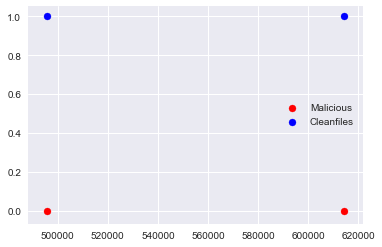

In [25]:
#lets plot
#let's label our dataframes
malicious['clean'] = 0
clean['clean'] = 1

import seaborn
%matplotlib inline
fig,ax = plt.subplots()
x = malicious['IATRVA']
y = malicious['clean']
ax.scatter(x,y,color='r',label='Malicious')
x1 = clean['IATRVA']
y1 = clean['clean']
ax.scatter(x1,y1,color='b',label='Cleanfiles')
ax.legend(loc="right")

We can notice the “clustering” of the Malicious samples on a tight centroid while the cleanfiles are sparse over the ‘x’ line let’s try now to plot other features as well to get an overall understanding of what we have here

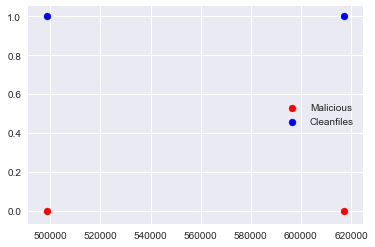

In [26]:
%matplotlib inline
fig,ax = plt.subplots()
x = malicious['DebugRVA']
y = malicious['clean']
ax.scatter(x,y,color='r',label='Malicious')
x1 = clean['DebugRVA']
y1 = clean['clean']
ax.scatter(x1,y1,color='b',label='Cleanfiles')
ax.legend(loc="right")

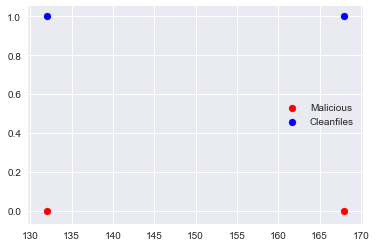

In [27]:
%matplotlib inline
fig,ax = plt.subplots()
x = malicious['ExportSize']
y = malicious['clean']
ax.scatter(x,y,color='r',label='Malicious')
x1 = clean['ExportSize']
y1 = clean['clean']
ax.scatter(x1,y1,color='b',label='Cleanfiles')
ax.legend(loc="right")

The more we plot and analyze the data the more we understand and get a sense of the overall distribution,of course a problem arises what do I do if I have a high-dimensional dataset well what we have here is fairly low dimensional but a lot of technics can be used to reduce the dimensions to the more “important” features algorithms like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and [t-SNE](https://lvdmaaten.github.io/tsne/) can be used to visualize the data on 3D or even 2D plots .

### Machine Learning Application

Enough with the statistics let’s do some work, till now we did not do any machine learning work what we did is part of the whole work we took some data, cleaned it and prepared it. Now to start experimenting with Machine Learning, we have to do a few more things:

- First, we need to merge our datasets (malicious and clean) into one DataFrame
- We need to split our DataFrame into two parts the first one will be used for training and later for testing
- We will then proceed to apply few algorithms and see what happens

### Merge datasets (CODE did not exist in the tutorial)

In [28]:
dataset_Merged = [malicious, clean]
dataset = pd.concat(dataset_Merged)
vec2csv(dataset.transpose(), 'dataset_Merged.csv');

### Dataset Preparation

In [29]:
"""
Add this points dataset holds our data
Great let's split it into train/test and fix a random seed to keep our predictions constant
"""
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#let's import 4 algorithms we would like to test
#neural networks
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
#random forests
from sklearn.ensemble import RandomForestClassifier
"""
Let's prepare our data
"""
state = np.random.randint(100)
y = dataset['clean']
X = dataset.drop('clean',axis = 1)
X = np.asarray(X)
y = np.asarray(y)
#X = X[:,1:]
print("The above line has been MODIFIED to remove the filename at the end.")
X = X[:,1:13]
print(X[1,11])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=0)

The above line has been MODIFIED to remove the filename at the end.
1048576


Now we have 4 Matrices quite big ones X_train and y_train will be used to train our different classifiers, and X_test will be used to predict the labels, and y_test will be used for metrics, in fact, we are going to compare the predictions from X_test to y_test to see how we did perform. We start by using **Random Forests** which are an ensemble version of [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree) they work by creating a lot of decision trees at training time and outputting the class that is the mode of the classes (classification), they are quite performant when it comes to binary classification problems

In [30]:
#let's start with random forests
#we initiate the classifier
clf1 = RandomForestClassifier()
#training
clf1.fit(X_train,y_train)
#prediction labels for X_test
y_pred=clf1.predict(X_test)
#metrics evaluation
"""
tn = True Negative a correct prediction clean predicted as clean
fp = False Positive a false alarm clean predicted as malicious
tp = True Positive a correct prediction (malicious)
fn = False Negative a malicious label predicted as clean
"""
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN = ",tn)
print("TP = ",tp)
print("FP = ",fp)
print("FN = ",fn)

TN =  0
TP =  0
FP =  0
FN =  1


Notice anything? Well if you have 6 False Positives and 4 False Negatives with no parameter tuning and no modifications are quite good,actually we were able to detect **697 Clean files correctly and 745 Malicious Ones Correctly**, guess our small Anti-Virus is working :D.

Let’s try this time another classifier, we will build a simple neural network and test it on another randomized split.

According to Wikipedia
- **A multilayer perceptron (MLP) is a feedforward artificial neural network model that maps sets of input data onto a set of appropriate outputs. An MLP consists of multiple layers of nodes in a directed graph, with each layer fully connected to the next one. Except for the input nodes, each node is a neuron (or processing element) with a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training the network. MLP is a modification of the standard linear perceptron and can distinguish data that are not linearly separable.**

A Multi-Layer Perceptron is the generalized version of the perceptron which is the basis model of the neuron they are the fundamental building blocks for deep learning methods where we meet larger and deeper networks.

In [31]:
#our usual split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=0)
#This is a special process called feature engineering where we transform our data into the same scale for better predictions
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#Here we build a Multi Layer Perceptron of 12 Layers for 12 Features  you can use more if you want but it will turn into a complex zoo
mlp = MLPClassifier(hidden_layer_sizes=(12,12,12,12,12,12))
#Training the MLP on our data
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
#evaluating our classifier
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
print("TN = ",tn)
print("TP = ",tp)
print("FP = ",fp)
print("FN = ",fn)

TN =  0
TP =  0
FP =  0
FN =  2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


The all mighty Neural Network failed to detect eighteen Threats not only that it detected them as clean files which is a very very bad problem imagine your antivirus detecting a ransomware as a clean file? Well this sounds like AV Evasion on AI but let’s not be pessimistic our Neural Network is very primitive we can actually make it more accurate, but this is beyond the scope of this article

### Conclusion:

This is just the beginning. I wanted to show that Malware Classification is indeed a solvable problem if we accept 99% as a good accuracy rate. Of course, building and deploying something like this, in reality, is time-consuming and requires more knowledge and more data. This was merely a preview of the infinite possibilities machine learning and AI, in general, offers us, I hope this was educational, fun and insightful.

### Resources:

Machine Learning Course by Andrew NG
https://fast.ai a Course that will make you a deep learning practitioner in 7 weeks only requirement (Python)
Elements of Statistical Learning (Harstie) this is a more theoretical book but quite insightful
http://2012.infosecsouthwest.com/files/speaker_materials/ISSW2012_Selecting_Features_to_Classify_Malware.pdf a quite insightful paper.